# Auditoria no Hospital de Trauma
## TC 013.515.2015-2
### Notebook para Análise Exploratória dos Dados obtidos por meio dos ofícios de requisição à Cruz Vermelha, entidade responsável pela adminstração do Hospital de Emergência e Trauma Senador Humberto Lucena - HEETSHL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import os

In [2]:
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('precision', 4)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.width', 5000)
# Mostra nossa versão do Pandas
%matplotlib inline
print('Versão do Pandas -> ', pd.__version__)

Versão do Pandas ->  0.20.3


### Caminhos e varíáveis globais

In [3]:
pasta_dados = os.path.join(os.getcwd(),'Dados')
pasta_dgi = os.path.join(os.getcwd(),'Cruzamentos DGI')
nome_arq_rh ='RELAÇÃO TCU {}.xlsx'
nome_planilha_rh = '{}.{}'
nome_arq_financeiro = 'Extratos_Financeiros.xlsx'

## Funções

In [4]:
def carregaDadosRH():
    """
     Carrega todos os dados dos arquivos do RH, 2015, 2016 e 2017, para um único Dataframe - Tidy data - retirando 
     os dados repetidos/redundantes.  
    """
    def getResponsaveis(ano):
        """
           Pega os dados dos responsáveis de um dado ano 
        """
        return pd.read_excel(os.path.join(pasta_dados, nome_arq_rh.format(ano)), sheetname= -1)
    
    def getPlanilha(ano, mes):
        """
           Importa uma planilha de arquivo xlsx com os dados dos servidores e contratados do Trauma, a partir do ano e mês informados,
           os quais devem ser STRING. Formato yyyy e mm    
        """    
        rh = pd.read_excel(os.path.join(pasta_dados, nome_arq_rh.format(ano)), sheetname = nome_planilha_rh.format(mes, ano))
        return rh 
    
    mes_tex = ""
    
    def getEmpregados(ano):
        frames = []
        # trabalha os meses do ano 
        for mes_num in range(1, 13):      
        ## begin-for   
            # formata o mês de acordo com a planilha dos dados
            if mes_num < 10: 
                mes_tex = '0' + str(mes_num)
            else: 
                mes_tex = str(mes_num)
            
            # se for o ano de 2017 e o mês for o 12, pula, porque não existe a planilha 
            if (ano == 2017) & (mes_tex == '12'): 
                continue
                
            # se for o ano de 2017 e o mês for o 6, pula porque não existe a planilha
            if (ano == 2017) & (mes_tex == '06'): 
                continue                              
                
            # pega os empregados da planilha atual
            df = getPlanilha(ano, mes_tex)
            df['Ano'] = ano
            df['Mes'] = mes_tex 
            # adiciona a planilha atual ao nosso conjunto de dataframes
            frames.append(df)
           
            
        ##end-for    
        
        
        # junta os dataframes 
        return pd.concat(frames)
   
    # loop nos anos
    for ano in range(2015, 2018):
    ### begin-for    
        if ano == 2015:
            df_empr2015 = getEmpregados(2015)            
            resp2015 = getResponsaveis(2015)
        if ano == 2016:
            # pega os empregados do ano e adiciona-os à lista de Dataframes
            df_empr2016 = getEmpregados(2016)  
            # pega os responsáveis do ano e adiciona-os à lista de Dataframes
            resp2016 = getResponsaveis(2016)
        if ano == 2017:            
            # adiciona à lista de Dataframes
            df_empr2017 = getEmpregados(2017)           
            resp2017 = getResponsaveis(2017)
    #### end-for                
    
    # concatena os dataframes de empregados para retornar
    df_empregados = pd.concat([df_empr2015, df_empr2016, df_empr2017])    
    # concatena os dataframes de responsáveis para retornar
    df_Resp = pd.concat([resp2015, resp2016, resp2017])
    
    # muda o tipo de dado do CPF de numérico para string nos responsáveis
    df_Resp['CPF'] = df_Resp['CPF'].astype(str)       
    # retorna uma tupla de Dataframes
    return (df_empregados, df_Resp)
        


In [5]:
def carregaContratos():
    """
       Lê o arquivo com os dados dos contratos e carrega-os num Dataframe, pegando ambas as planilhas do .xlsx       
    """
    panel_contratos = []
    panel_contratos.append(pd.read_excel(os.path.join(pasta_dados, 'Contratos_Trauma.xlsx'), sheetname= 0, skiprows=3))
    panel_contratos.append(pd.read_excel(os.path.join(pasta_dados, 'Contratos_Trauma.xlsx'), sheetname= 1, skiprows=3))
    # junta os dois dataframes e os retorna
    return pd.concat(panel_contratos)

    

In [6]:
def retiraMascaraCNPJ(df, campo_cnpj='CNPJ'):
    """
       retira a máscara do CNPJ de um dataframe. 
       Parameters: [df: dataframe que contém a coluna de CNPJ]
                   [campo_cnpj: nome do campo que tem o CNPJ]
    """
    df[campo_cnpj] = df[campo_cnpj].str.replace('.', '')
    df[campo_cnpj] = df[campo_cnpj].str.replace('/', '')
    df[campo_cnpj] = df[campo_cnpj].str.replace('-', '')    
    

In [7]:
def carregaCruzamentosDGI():
    """
       Carrega os datasets vindos do DGI consultas. 
       OBS: Deve-se converter os arquivos .csv que vêm do DGI consultas para .xlsx
    """
    path_cnpj = os.path.join(pasta_dgi, 'CNPJ.xlsx')
    # dados primário do CNPJ como endereço, data de abertura da empresa etc.
    df_cnpj = pd.read_excel(path_cnpj)    
    
    return df_cnpj    

## Carrega os cruzamentos feitos no  do DGI

In [8]:
df_cnpj = carregaCruzamentosDGI()

retiraMascaraCNPJ(df_cnpj)

## Dados dos Recursos Humanos

### Descrição dos dados enviados

- Foram enviados 3 arquivos do MS-Excel (.xlsx), sendo 1 para cada ano, 2015, 2016 e 2017, contendo os dados de todos os contratados, efetivos e dos responsáveis pela gestão.  
- Cada arquivo contem 12 planilhas, nomeadas segundo o padrão mm.aaaa. Ex: 01.2015, 02.2015, 01.2016, 10.2017 etc.

### Layout dos dados

- Cada Planilha, em geral, apresenta o seguinte layout (colunas): NOME, CPF, FUNÇÃO E VÍNCULO.
- No entanto, algumas planilhas apresentam layout diferente, a exemplo da 11.2015: MAT., NOME,	FUNÇÃO,	VINCULO  
- O arquivo com os dados de 2017 apresenta o seguinte layout, a partir da planilha 03.2017: MAT.,NOME,CPF,FUNÇÃO,VINCULO
- Ao final de cada um dos 3 arquivos, há uma planilha denominada de RESPONSÁVEIS, que possui os campos: NOME,CPF,FUNÇÃO,DATA ADMISSÃO,DATA SAÍDA,VINCULO

## Carregando os dados do RH

In [9]:
df_Empregados, df_Responsaveis = carregaDadosRH()

In [10]:
df_Empregados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67406 entries, 0 to 2056
Data columns (total 8 columns):
Ano        67406 non-null int64
CPF        65444 non-null object
FUNÇÃO     67405 non-null object
MAT.       18122 non-null float64
Mes        67406 non-null object
NOME       63297 non-null object
NOME       4108 non-null object
VINCULO    67406 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 4.6+ MB


In [11]:
df_Empregados.columns

Index(['Ano', 'CPF', 'FUNÇÃO', 'MAT.', 'Mes', 'NOME', 'NOME ', 'VINCULO'], dtype='object')

In [12]:
# apaga a segunda coluna de nome
df_Empregados.drop(df_Empregados.columns[-2], axis = 1, inplace=True)

In [13]:
# altera o tipo da matrícula
df_Empregados['MAT.'] =  df_Empregados['MAT.'].astype(str)

In [14]:
df_Empregados.head(200).sort_values(by="NOME")

      Ano          CPF                          FUNÇÃO MAT. Mes                                NOME  VINCULO
0    2015  67391400491  TEC  IMOB ORTOPEDICA            nan  01  ADALBERTO FELINTO CARDOSO FILHO     CVB CLT
1    2015  10141457406  RECEPCIONISTA                   nan  01  ADEIKSON CARLOS ALVES DE MORAIS     CVB CLT
2    2015   2322399400  TECNICO DE ENFERMAGEM - I       nan  01  ADEILZE KATIA DA SILVA LIMA         CVB CLT
3    2015   5985349462  AUX ADMINISTRATIVO              nan  01  ADEIRES COSTA MOREIRA               CVB CLT
4    2015    242977472  MEDICO ANESTESIOLOGISTA         nan  01  ADELCIDIO PEREIRA                   CVB CLT
5    2015   8876008756  TEC DE ENFERMAGEM - EFETIV      nan  01  ADELIANO FRANCISCO DA SILVA NETO    EFETIVO
6    2015  36425044420  TEC EM RADIOLOGIA - EFET        nan  01  ADELMO HEBERTE DO NASCIMENTO        EFETIVO
7    2015  13264737434  MEDICO CARDIOLOGISTA - EFETIVO  nan  01  ADEMAR MARTINS DA SILVA             EFETIVO
8    2015  97024490

### Pesquisa por um string parcial

In [78]:
df_Empregados[df_Empregados['NOME'].str.contains('LEANDRO TORRES', na=False)].sort_values(by=['Ano', 'Mes'])

      Ano         CPF                          FUNÇÃO    MAT. Mes                                NOME  VINCULO
917  2017  5739208424  MEDICO CIRURGIAO GERAL          3722.0  07  LEANDRO TORRES ANDRADE DA NOBREGA   CVB CLT
927  2017  5739208424  MEDICO CIRURGIAO GERAL          3722.0  08  LEANDRO TORRES ANDRADE DA NOBREGA   CVB CLT
913  2017  5739208424  MEDICO CIRURGIAO GERAL          3722.0  09  LEANDRO TORRES ANDRADE DA NOBREGA   CVB CLT
910  2017  5739208424  MEDICO CIRURGIAO GERAL          3722.0  10  LEANDRO TORRES ANDRADE DA NOBREGA   CVB CLT
904  2017  5739208424  MEDICO CIRURGIAO GERAL          3722.0  11  LEANDRO TORRES ANDRADE DA NOBREGA   CVB CLT

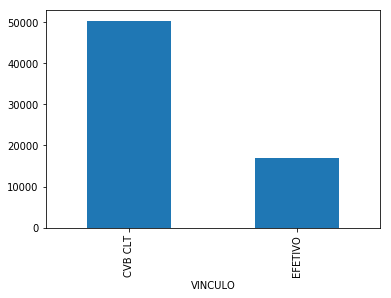

In [16]:
df_Empregados.groupby(['VINCULO'])['VINCULO'].count().sort_values(ascending=False).plot(kind='Bar')

In [17]:
pd.pivot_table(data = df_Empregados, index= ['VINCULO', 'FUNÇÃO'], values=['CPF'], aggfunc='count')

                                         CPF
VINCULO FUNÇÃO                              
CVB CLT AGENTE ADMINISTRATIVO              8
        AGENTE ADMINISTRATIVO            251
        AJUDANTE DE COZINHA               32
        ANALISTA DE SUPORTE                3
        ANALISTA DP                        1
        ANALISTA DP                       30
        ANALISTA FINANCEIRO                1
        ANALISTA FINANCEIRO               32
        ANALISTA RH                        2
        ANALISTA RH                       83
        APOIO                             64
        APOIO                           1977
        APRENDIZ                          22
        APRENDIZ                         736
        ARQUITETO                          1
        ARQUITETO                         32
        ASSESSOR DA DIRECAO                4
        ASSESSOR DA DIRECAO               93
        ASSESSOR DE COMUNICAO              3
        ASSESSOR DE COMUNICAO            122
        AS

In [18]:
df_Responsaveis
df_Responsaveis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 2
Data columns (total 6 columns):
NOME             14 non-null object
CPF              14 non-null object
FUNÇÃO           14 non-null object
DATA ADMISSÃO    14 non-null datetime64[ns]
DATA SAÍDA       3 non-null object
VINCULO          14 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 784.0+ bytes


In [19]:
df_Responsaveis

                                 NOME          CPF                          FUNÇÃO DATA ADMISSÃO           DATA SAÍDA  VINCULO
0  EDVAN BENEVIDES DE FREITAS JUNIOR    1026573432  DIRETOR TECNICO                   2011-07-07                  NaN  CVB CLT
1  FERNANDA RIBEIRO FONSECA             7763773707  DIRETOR GERAL                     2014-03-08          31/12/20115  CVB CLT
2  MILTON PACIFICO JOSE ARAUJO         16914058091  SUPERINTENDENTE                   2013-10-01                  NaN  CVB CLT
3  SABRINA GRASIELLE DE CASTRO BERNAR   3523785650  DIRETOR DE ASSISTENCIA            2014-04-01                  NaN  CVB CLT
4  SIDNEY DA SILVA SCHMID              39727360700  DIRETOR ADMINISTRATIVO            2012-01-24                  NaN  CVB CLT
5  SILVIO ANTONIO MOTA GUERRA          82574510704  DIRETOR FINANCEIRO                2011-07-07                  NaN  CVB CLT
0  EDVAN BENEVIDES DE FREITAS JUNIOR    1026573432  DIRETOR TECNICO                   2011-07-07  2016-03-31 00

### Exporta o CPF dos empregados/servidores para cruzamentos

In [20]:
cpf_empre = df_Empregados['CPF'].astype(str)
cpf_resp = df_Responsaveis['CPF'].astype(str)
print(cpf_resp.size)
print(cpf_empre.size)


cpf_resp = cpf_resp.drop_duplicates()

cpfs = pd.concat([cpf_empre, cpf_resp])
cpfs.to_csv('cpfs.csv', index=False)

14
67406


In [21]:
cpf_empre.count()

67406

In [22]:
cpf_resp.count()

6

## Carrega os contratos

### Descrição dos dados enviados

- Foi enviada um arquivo excel contendo duas planilhas, nominadas, respectivamente: "Contrato 061-2012" e "contratos 0223-2017" 


### Layout dos dados
As planilhas supracitadas possuem os seguintes campos:EMPRESA,CNPJ DO CREDOR,OBJETO RESUMIDO,INÍCIO,TÉRMINO,VIGENCIA APÓS ADITIVO

In [23]:
df_contratos = carregaContratos()

In [24]:
df_contratos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 22
Data columns (total 13 columns):
CNPJ DO CREDOR           55 non-null object
Demanda                  9 non-null object
EMPRESA                  55 non-null object
INÍCIO                   55 non-null datetime64[ns]
OBJETO RESUMIDO          55 non-null object
TÉRMINO                  55 non-null datetime64[ns]
Unnamed: 10              0 non-null float64
Unnamed: 11              0 non-null float64
Unnamed: 12              1 non-null float64
Unnamed: 8               0 non-null float64
Unnamed: 9               0 non-null float64
VIGENCIA APÓS ADITIVO    55 non-null datetime64[ns]
Valor Mensal(R$)         21 non-null float64
dtypes: datetime64[ns](3), float64(6), object(4)
memory usage: 6.0+ KB


In [25]:
# Renomeia o CNPJ
df_contratos.rename(columns={'CNPJ DO CREDOR': 'CNPJ'}, inplace=True)

In [26]:
# retira a sua máscara para poder fazer os cruzamentos 
retiraMascaraCNPJ(df_contratos)


In [27]:
df_contratos[['EMPRESA','CNPJ', 'INÍCIO', 'TÉRMINO', 'Valor Mensal(R$)']].sort_values(by=['CNPJ'])

                                              EMPRESA            CNPJ     INÍCIO    TÉRMINO  Valor Mensal(R$)
5        EIQUIP SOLUÇÕES EM EQUIPAMENTOS MÉDICOS LTDA  01242766000145 2017-07-01 2019-07-01        223,817.34
6        EIQUIP SOLUÇÕES EM EQUIPAMENTOS MÉDICOS LTDA  01242766000145 2016-07-18 2019-07-18               nan
0                  COPY LINE COMERCIO E SERVIÇOS LTDA  02914690000110 2017-07-01 2018-07-01               nan
16                       RESGATE KM ESPRESSE LTDA ME   03112378000175 2017-02-23 2018-02-23               nan
10                       RESGATE KM ESPRESSE LTDA ME   03112378000175 2017-07-01 2018-07-01         16,000.00
2           LYNN CONSULTORIA DE RECURSOS HUMANOS LTDA  04715048000137 2017-07-01 2018-07-01        555,148.02
14          LYNN CONSULTORIA DE RECURSOS HUMANOS LTDA  04715048000137 2016-11-01 2017-11-01               nan
13          LYNN CONSULTORIA DE RECURSOS HUMANOS LTDA  04715048000137 2015-03-21 2016-03-21               nan
12        

### Exporta o CNPJ dos contratos para cruzamento no DGI

In [28]:
cnpj = df_contratos['CNPJ'].sort_values()

In [29]:
# remove os duplicados
cnpj.drop_duplicates(inplace=True)

In [30]:
cnpj.to_csv('contratos_trauma.csv', index=False)

## Financeiro

In [31]:
# Lê o arquivo Excel todo
arq_excel_financ = pd.ExcelFile(os.path.join(pasta_dados, nome_arq_financeiro))
# loop nas planilhas do arquivo
contas = []
for planilha in arq_excel_financ.sheet_names:
## begin-for    
   df_planilha = arq_excel_financ.parse(planilha)
   df_planilha['Ano'] = planilha
   contas.append(df_planilha)

## end-for        
df_Financeiro = pd.concat(contas)    

In [32]:
df_Financeiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12702 entries, 0 to 4426
Data columns (total 10 columns):
Ano              12702 non-null object
CNPJ             8262 non-null object
DATA             12701 non-null object
DISCRIMINAÇÃO    12696 non-null object
ENTRADA          495 non-null float64
FORNECEDOR       12702 non-null object
NF               8248 non-null object
NOTA FISCAL      2749 non-null object
SALDO            4427 non-null object
SAÍDA            12702 non-null float64
dtypes: float64(2), object(8)
memory usage: 1.1+ MB


In [33]:
df_Financeiro.set_index('FORNECEDOR', inplace=True)

In [34]:
df_Financeiro.rename(columns={'DATA ':'DATA'}, inplace=True)

In [35]:
df_Financeiro[['CNPJ', 'ENTRADA', 'SAÍDA']]

                                                                  CNPJ      ENTRADA        SAÍDA
FORNECEDOR                                                                                      
Saldo de Dezembro 2014                                               -         0.00         0.00
Devolução                                                9125576000150    49,694.38         0.00
Pronto Socorro Cardiológico - HTOP - Prontocor -         9125576000150          nan    49,694.38
Hidraudiesel Serviços Hidraúlicos LTDA                   6076888000122          nan     2,946.50
Andrezza Quirino Ramalho de Moura                       060.627.314-03          nan     3,495.64
Ana Elizabeth B. Rodrigues Dantas                       144.247.544-72          nan       888.93
Classe A Representações Ltda - Me                        4005545000141          nan   143,732.07
Folha de Pagamento                                       8778268000160          nan    18,000.00
Companhia De Água E Esgotos Da

### Exclui a linha denominada de "Total de Saídas" para evitar erro nos valores

In [36]:
df_Financeiro.drop('TOTAL DE SAÍDAS', inplace=True)

In [37]:
pivot_financ_forn = pd.pivot_table(data = df_Financeiro, index= ['FORNECEDOR'], values=['SAÍDA'], aggfunc='sum')

In [38]:
pivot_financ_forn.sort_values(by='SAÍDA', ascending=False)

                                                           SAÍDA
FORNECEDOR                                                      
Folha de Pagamento                                 97,263,908.30
BB renda fixa                                      63,993,904.06
Folha de pagamento                                 21,460,365.21
Cooperativa Neuroc Neurol Cir Vasculares           20,708,721.02
Coort - Pb Coop Ortop Traumatologia Pb             19,774,576.13
Gastronomia Nordeste Com Serv Alimentos            17,861,052.02
Cooperativa Dos Cirurgiões Da Paraíba              12,760,563.80
Lynn Consultoria De Recursos Humanos Ltd           11,688,987.16
FGTS                                               11,357,192.36
INSS Empregados                                     9,110,667.67
Imobras Empreendimentos Imobiliários Ltd            9,070,120.72
Folha de Férias                                     8,391,853.99
Engemed - Engenharia E Consultoria Ltda             6,911,810.43
Energisa Paraíba - Distri

### Exporta para o Excel a lista de pagamentos feitos

In [39]:
pivot_financ_forn.to_excel('pagamentos_fornecedor.xlsx')

### Os maiores destinatários de recursos do Trauma (2015-2017)

In [40]:
pag_acima_milhao = pivot_financ_forn[pivot_financ_forn['SAÍDA'] > 5000000].sort_values(by='SAÍDA', ascending=False)

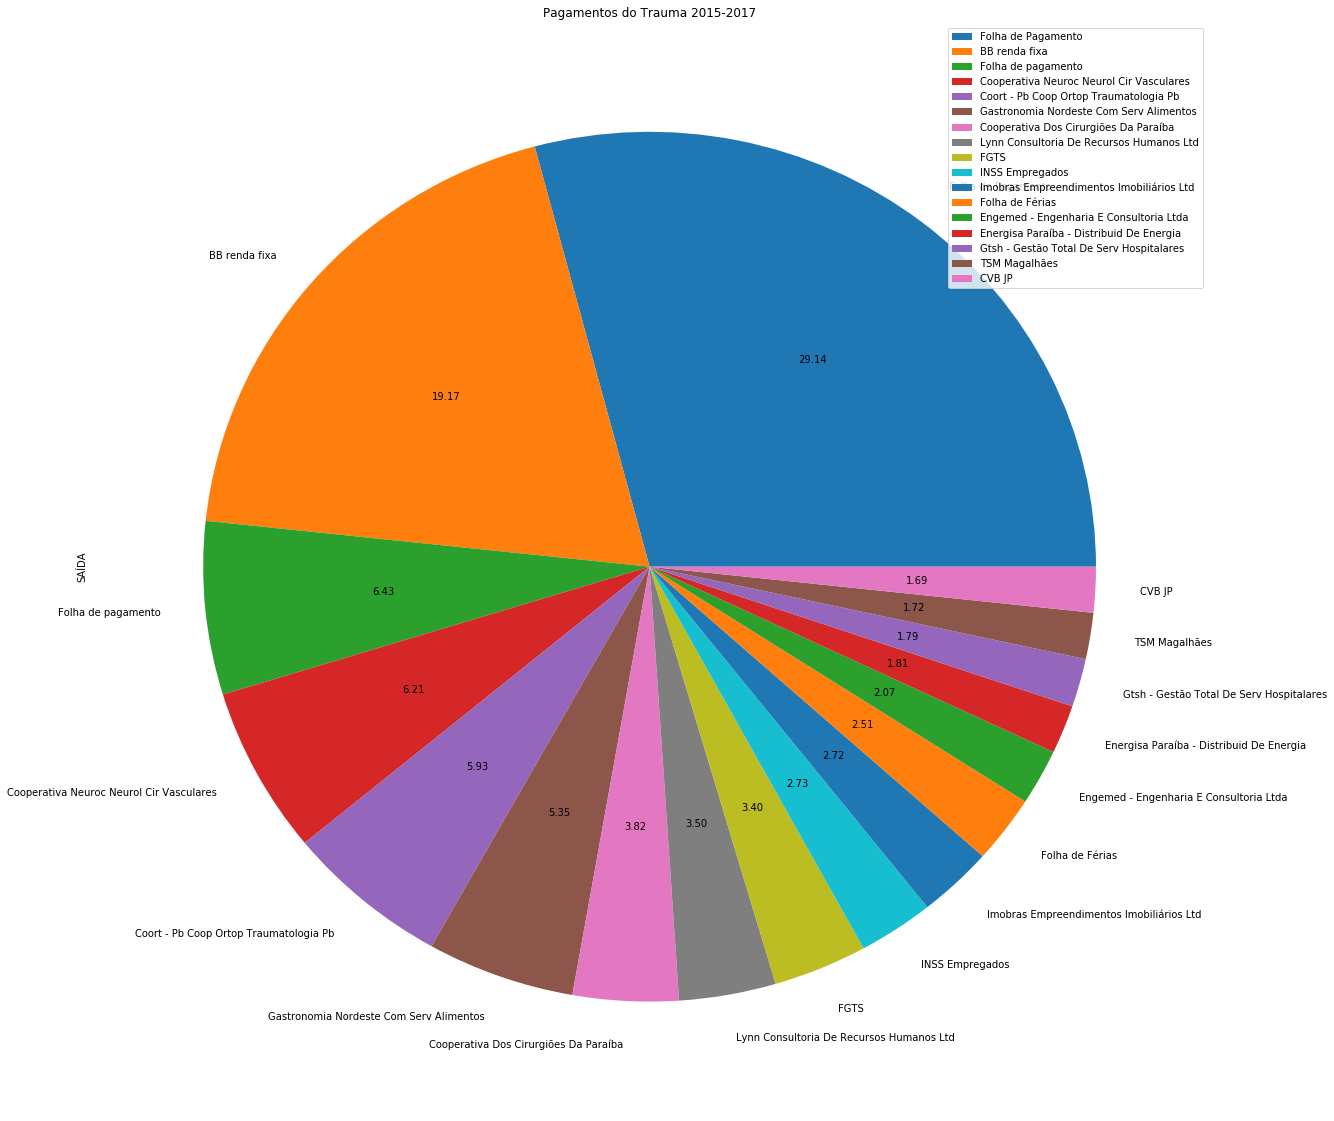

In [41]:
pag_acima_milhao.plot(kind='pie', y='SAÍDA', figsize=(20, 20), grid=True, legend=True, autopct='%.2f', 
                      title='Pagamentos do Trauma 2015-2017')

### Análise da variável "Saída" que representa os valores pagos pelo Trauma

In [49]:
df_Financeiro['SAÍDA'].describe()

count       12,701.00
mean        36,736.29
std        266,289.80
min              0.00
25%             41.53
50%          1,710.67
75%          9,385.00
max     12,706,300.00
Name: SAÍDA, dtype: float64

### Comentários
- 25% dos 12.701 pagamentos estão abaixo de R$ 42 (1º Quartil)

- 50% abaixo de R$ 1.800,00 (2º Quartil)

### Agrupa e totaliza os valores do primeiro quartil (os 25% menores pagamentos)

In [71]:
df_Financeiro[df_Financeiro['SAÍDA'] < 42]['SAÍDA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Tarifa DOC/TED Eletrônico.                             21,275.52
Tarifa Pag Salário Crédito em Conta                       401.58
Sind Enfermeiros no Estado da Paraíba                     158.90
Folha de Pagamento                                        146.96
Folha de pagamento                                        138.78
IRRF                                                      136.25
Tarifa Lib/Ant Float Pag Salário                           86.09
Bloqueio Judicial                                          75.35
PIS/COFINS/CSLL                                            58.42
Tarifa Pacote de Serviços                                  55.50
Pagamento Trabalhista                                      44.04
Shopping da Criança LTDA - ME                              40.00
Alexsandra Lima da Silva                                   38.33
Josivando Alexandre de Oliveira                            36.00
Laboratório de Patologia Clínica S/S Limitada Hemato       31.70
Rodrigues Albu

### Agrupa e totaliza os valores entre o primeiro e o segundo quartil

In [75]:
df_Financeiro[(df_Financeiro['SAÍDA'] > 42) & (df_Financeiro['SAÍDA'] < 1710)]['SAÍDA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Folha de Pagamento                                                                      567,241.44
Folha de pagamento                                                                       89,287.05
Tarifa Pag Salário Crédito em Conta                                                      54,017.05
Tribunal Regional do Trabalho                                                            52,143.55
Tarifa Lib/Ant Float Pag Salário                                                         49,130.17
Energisa Paraíba - Distribuid De Energia                                                 47,750.07
FGTS Rescisório                                                                          40,484.06
Epimed Solutions Tecnologia Info Médicas                                                 39,969.33
Unimed João Pessoa Coop Trab Médico                                                      29,185.74
Oi Móvel S.A.                                                                            27,353.00

### Agrupa e totaliza os valores do terceiro quartil (75% maiores pagamentos)

In [76]:
df_Financeiro[df_Financeiro['SAÍDA'] > 9385]['SAÍDA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Folha de Pagamento                                                                          94,896,292.46
BB renda fixa                                                                               63,984,904.06
Folha de pagamento                                                                          21,020,205.24
Cooperativa Neuroc Neurol Cir Vasculares                                                    20,703,686.26
Coort - Pb Coop Ortop Traumatologia Pb                                                      19,758,162.88
Gastronomia Nordeste Com Serv Alimentos                                                     17,861,052.02
Cooperativa Dos Cirurgiões Da Paraíba                                                       12,753,729.61
Lynn Consultoria De Recursos Humanos Ltd                                                    11,680,958.89
FGTS                                                                                        11,341,861.75
INSS Empregados                    

### <span style='color:red'> Leandro Torres Andrade da Nóbrega - Valor pago  R$ 3.450.358,45 </span>                                                        
#### Valor muito alto pago a uma pessoa física


### Pivot Table para vizualizar os pagamentos feitos a fornecedores por ano

In [85]:
pivot_financ_forn_ano = pd.pivot_table(data = df_Financeiro, 
                                       index= ['FORNECEDOR'], 
                                       columns=['Ano'],
                                       values=['SAÍDA'],                                
                                       aggfunc='sum')

In [81]:
pivot_financ_forn_ano

                                                          SAÍDA                           
Ano                                                        2015         2016          2017
FORNECEDOR                                                                                
A R Rodrigues de Oliveira                                   nan          nan      8,742.00
A União Superintendência de Imprensa e Editora         2,840.00     3,480.00           nan
A União Superitendência de Imprensa e Editora            500.00       300.00           nan
ABS Frio Serviços Ltda - ME                                 nan    77,900.00           nan
AETC - Ass Emp Transp Coletivos Urbanos João Pe...    52,214.68          nan           nan
AETC - Ass. Emp. Transp. Colet. Urb. JP               38,257.07          nan           nan
Abril Comunicações                                    58,665.58          nan           nan
Acionador Médico Comércio Ltda - Epp                  42,326.00          nan           nan

### Ordena o dataframe do pivot pelos maiores valores pagos

In [80]:
pivot_financ_forn_ano.sort_values(by=pivot_financ_forn_ano.columns[0], ascending=False)

                                                           SAÍDA                            
Ano                                                         2015          2016          2017
FORNECEDOR                                                                                  
Folha de Pagamento                                 39,021,258.04 41,619,206.40 16,623,443.86
Coort - Pb Coop Ortop Traumatologia Pb              7,124,549.75  8,051,685.55  4,598,340.83
Cooperativa Neuroc Neurol Cir Vasculares            6,265,603.77  7,142,224.43  7,300,892.82
Cooperativa Dos Cirurgiões Da Paraíba               4,220,465.01  5,356,405.01  3,183,693.78
FGTS                                                3,334,335.85  3,806,829.80  4,216,026.71
Imobras Empreendimentos Imobiliários Ltd            2,752,906.37  3,572,753.25  2,744,461.10
Lynn Consultoria De Recursos Humanos Ltd            2,224,109.40  4,249,128.08  5,215,749.68
Folha de Férias                                     2,148,313.45  3,03

### Exporta a listagem de pagamentos por ano

In [194]:
pivot_financ_forn_ano.to_excel('pagamentos_fornecedor_ano.xlsx')

### Gastos anuais do Trauma

In [227]:
gastos_ano = df_Financeiro.groupby('Ano')['SAÍDA'].sum()

In [228]:
gastos_ano

Ano
2015   117,149,739.46
2016   142,149,006.11
2017   207,288,813.64
Name: SAÍDA, dtype: float64

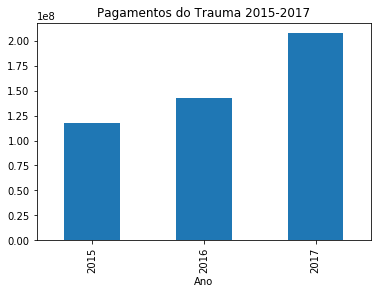

In [238]:
gastos_ano.plot(kind='bar', legend=False,title='Pagamentos do Trauma 2015-2017',  )

### Análise das Entradas de Recursos

In [88]:
df_Financeiro['ENTRADA'].groupby('FORNECEDOR').sum().sort_values(ascending=False)

FORNECEDOR
Repasse da Sec. Estado da Saúde                                                             353,977,865.79
BB renda fixa                                                                                63,749,754.84
Repasse da Secretaria de Estado da Saúde                                                     30,391,193.86
CVB JP                                                                                        5,647,886.71
Devolução                                                                                     2,103,697.91
TED Crédito em Conta - MATRIZ                                                                   480,009.59
TED Crédito em Conta                                                                            337,704.07
Desbloqueio Judicial                                                                            316,816.13
CVB RJ                                                                                          315,974.75
Desbloqueio Judicial\nTrib

### Filtra para termos apenas valores de entrada válido

In [112]:
df_entradas = df_Financeiro[df_Financeiro['ENTRADA'].notnull()]

In [113]:
pivot_financ_entradas_ano = pd.pivot_table(data = df_entradas, 
                                           index= ['FORNECEDOR'], 
                                           columns=['Ano'],
                                           values=['ENTRADA'],                                
                                           aggfunc='sum')

### exporta a pivot table com os valores de entrada

In [115]:
pivot_financ_entradas_ano.sort_values(by=pivot_financ_entradas_ano.columns[2], ascending=False).to_excel('entradas_ano.xlsx')

In [110]:
pivot_financ_entradas = pd.pivot_table(data = df_entradas, 
                                           index= ['FORNECEDOR'], 
                                           columns=['Ano'],
                                           values=['ENTRADA'],                                
                                           aggfunc='sum')

In [119]:
pivot_financ_entradas.sort_values(by=pivot_financ_entradas.columns[2], ascending=False)

                                                          ENTRADA                              
Ano                                                          2015           2016           2017
FORNECEDOR                                                                                     
Repasse da Sec. Estado da Saúde                    106,167,278.20 110,471,208.76 137,339,378.83
BB renda fixa                                                 nan            nan  63,749,754.84
CVB JP                                                        nan            nan   5,647,886.71
Devolução                                              692,921.07     910,591.03     500,185.81
TED Crédito em Conta                                          nan            nan     337,704.07
CVB RJ                                                        nan            nan     315,974.75
Desbloqueio Judicial\nTribunal Regional do Trab...            nan            nan      78,561.61
TED Crédito em Conta - MATRIZ           